In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
import torchvision.datasets as D
import torch.nn.functional as F
import numpy as np
import pickle
from matplotlib import pyplot as plt
from torchvision.io import read_image
from torchvision import transforms
from torch.utils.data import DataLoader
import fiona
import rasterio
import rasterio.mask
import pathlib
import pandas as pd
import os
import rioxarray
import sys
from tqdm import tqdm
sys.path.append("../src/")
from networks.ModisTempNet import ModisTempNet

In [2]:
class MyDataset(torch.utils.data.Dataset):
    """Creates dataset that sampes: (landscape, class).
    Args:
        root (str): directory where data is being stored
        tform (Transform): tranformation to be applied at sampling time.
    """
    def __init__(self, root="./Ventanas", tform=None):
        super(MyDataset, self).__init__()
        self.root = root
        self.classification = pd.read_csv(f'{self.root}/database.csv')
        unique_classes = self.classification.clase.unique()
        self.translation = {}
        for i, j in zip(unique_classes, [k for k in range(len(unique_classes))]):
            self.translation[i] = j
        self.n_classes = len(self.translation)
        self.transform = tform
        imgs = os.listdir(f"{self.root}/")
        self.maxes = {}
        self.mins = {}
        for i in imgs:
            if i.split(".")[1] == "tif" and len(i.split(".")) == 2:
                src = rasterio.open(self.root + "/" + i)
                data = src.read()
                for band in range(data.shape[0]):
                    if band in self.maxes.keys():
                        if np.max(data[band]) > self.maxes[band]:
                            self.maxes[band] = np.max(data[band])
                        if np.min(data[band]) < self.mins[band]:
                            self.mins[band] = np.min(data[band])
                    else:
                        self.maxes[band] = np.max(data[band])
                        self.mins[band] = np.min(data[band])
        for band in range(data.shape[0]):
            self.mins[band] -= 1
        
        
    def __len__(self):
        return len(self.classification)
    
    def __getitem__(self, i):
        id_, class_ = self.classification.iloc[i]
        src = rasterio.open(f'{self.root}/ID{id_}.tif')
        data = src.read()
        n_class = self.translation[class_]
        y = torch.zeros(self.n_classes)
        y[n_class] = 1.
        x = torch.from_numpy(data[:,:10,:10])
        n_bands = x.shape[0]
        for i in range(n_bands):
            x[i] = torch.where(torch.isnan(x[i]), self.mins[i], x[i])
        if torch.isnan(x).sum():
            print(x)
            print("Error")
        for band in range(n_bands):
            x[band] = (x[band] - self.mins[band]) / (self.maxes[band] - self.mins[band])
        if self.transform:
            x = self.transform(x)
        return x, y

In [3]:
class Resize(object):
    def __call__(self, x):
        x = transforms.functional.resize(x, size = 256, interpolation = transforms.InterpolationMode.NEAREST_EXACT)
        return x

In [4]:
transform = transforms.Compose([Resize()])

In [5]:
dataset = MyDataset(tform = transform)

In [6]:
train_dataset, validation_dataset, test_dataset =torch.utils.data.random_split(dataset, [0.8, 0.1, 0.1])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=8)
test_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8)

In [7]:
net = ModisTempNet()
net.cuda()

ModisTempNet(
  (conv1): Conv2d(71, 16, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (max_pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (max_pool_2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (max_pool_3): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (fc_1): Linear(in_features=5408, out_features=256, bias=True)
  (bn4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_2): Linear(in_features=256, out_features=128, bias=True)
  (bn5): BatchNorm1d(128, eps=1e-05, momentum=

  0%|          | 0/2 [00:00<?, ?it/s]/home/lu/Desktop/Trabajo/fuel-model/venv/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████| 2/2 [02:49<00:00, 84.60s/it]


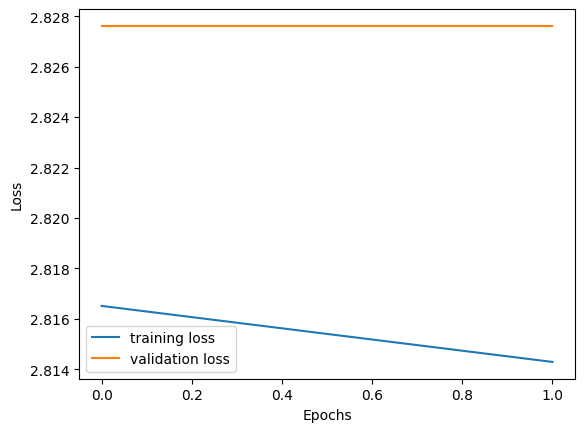

In [8]:
epochs = 2
optimizer = torch.optim.Adam(net.parameters())
for epoch in tqdm(range(epochs)):
    for x, y in train_loader:
        net.zero_grad()
        pred = net(x.cuda())
        loss = net.train_loss(pred, y.cuda())
        loss.backward()
        optimizer.step()
    
    for x, y in validation_loader:
        pred = net(x.cuda())
        loss = net.val_loss(pred, y.cuda())
    net.reset_losses()
net.plot_loss(epochs=epochs)



In [ ]:
net.validation_loss

[0.0, 0.0, 0.0, 0.0, 0.0]